# EDA

## Introducción

Default Probability Prediction
Este proyecto busca mejorar la predicción del riesgo de impago (default) en tarjetas de crédito, lo que es clave para optimizar la gestión del riesgo crediticio y la toma de decisiones de los prestamistas. El objetivo es desarrollar un modelo eficiente mediante el uso de técnicas de machine learning aplicadas a un conjunto de datos a gran escala, que contiene información anonimizada de clientes y su comportamiento financiero.

El modelo pretende no solo predecir mejor los defaults, sino también mejorar la experiencia del cliente al facilitar la aprobación de tarjetas de crédito y reducir los riesgos para las instituciones financieras. Esto no solo tendrá un impacto en la optimización de los productos financieros, sino que también podría abrir oportunidades para nuevas carreras y mejoras en la interacción entre clientes y entidades financieras.

## Diccionario de variables
D_ = Delinquency variables*
Estas variables representan la morosidad en el pago de las deudas. Se registran para cada cliente y reflejan el comportamiento con respecto al cumplimiento de los pagos.

S_ = Spend variables*
Las variables de gasto reflejan los patrones de gasto del cliente a lo largo del tiempo. Estas variables muestran cuánto gasta un cliente en su tarjeta de crédito.

P_ = Payment variables*
Estas variables describen los pagos realizados por el cliente. Incluyen información sobre los montos de pago y la frecuencia de los pagos.

B_ = Balance variables*
Las variables de balance describen el saldo de la cuenta de un cliente en un momento dado, lo que indica cuánto debe el cliente.

R_ = Risk variables*
Las variables de riesgo proporcionan una evaluación del nivel de riesgo asociado con el perfil crediticio del cliente.

Variables categóricas
- B_30
- B_38
- D_114
- D_116
- D_117
- D_120
- D_126
- D_63
- D_64
- D_66
- D_68

Estas variables son categóricas y representan características específicas del perfil financiero y de comportamiento del cliente, como métricas discretas sobre los pagos, balance o morosidad.

- **train_data.ftr**: Datos de entrenamiento con múltiples fechas de estado de cuenta por `customer_ID` Junto con la variable target.
- **test_data.ftr**: Etiqueta objetivo para cada `customer_ID` eb base al modelo saliente del train.

## Librerias y carga de Datasets



In [1]:
!pip install pandas
!pip install dask[dataframe]
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install category_encoders
!pip install imbalanced-learn
!pip install scikit-optimize
!pip install ace_tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.2 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.4 MB/s eta 0:00:00


In [4]:
# Manipulación de Datos
import pandas as pd
import dask.dataframe as dd
import numpy as np

# Visualización de Datos
import matplotlib.pyplot as plt
import seaborn as sns

# Manejo de Archivos
from google.colab import drive
from google.colab import files
import io
import pickle

# Imputación y Procesamiento de Datos
from sklearn.experimental import enable_iterative_imputer  # Habilitar IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import category_encoders as ce
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Manejo de Desequilibrio de Datos
from imblearn.over_sampling import ADASYN

# Modelos de Clasificación
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Métricas de Evaluación
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

# División de Datos
from sklearn.model_selection import train_test_split

# Búsqueda de Hiperparámetros
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Pipelines de Modelos
from imblearn.pipeline import Pipeline

# Utilidades Varias
import warnings
import time

drive.mount('/content/drive')
test=pd.read_feather('/content/drive/MyDrive/Parcial 2/DATA/test_data.ftr')
df= pd.read_feather('/content/drive/MyDrive/Parcial 2/DATA/train_data.ftr')

df.head()

test.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631348,0.001912,0.010727,0.814453,0.007545,0.168701,0.009972,0.002348,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008278,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.586914,0.005276,0.011024,0.811035,0.001817,0.241333,0.000166,0.009132,...,NaN,NaN,NaN,0.000142,0.004940,0.009018,NaN,0.003695,0.003754,0.001460
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.608887,0.003326,0.016388,1.004883,0.000114,0.267090,0.004196,0.004192,...,NaN,NaN,NaN,0.000074,0.002113,0.004658,NaN,0.003155,0.002155,0.006481
3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-05-20,0.614746,0.009064,0.021667,0.816406,0.009720,0.188965,0.004124,0.015327,...,NaN,NaN,NaN,0.004742,0.006393,0.002890,NaN,0.006042,0.005207,0.007858
4,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-06-15,0.591797,0.238770,0.015930,0.810547,0.002026,0.180054,0.000731,0.011284,...,NaN,NaN,NaN,0.008133,0.004330,0.008385,NaN,0.001008,0.007420,0.009468


In [5]:
warnings.filterwarnings("ignore")

## Datos

Este código realiza un análisis exploratorio de los datos, calculando estadísticas descriptivas como la media, desviación estándar, mínimo, máximo y cuartiles para las variables numéricas. También cuenta los datos faltantes por columna y su porcentaje. Finalmente, genera un histograma para la variable respuesta categórica (target).

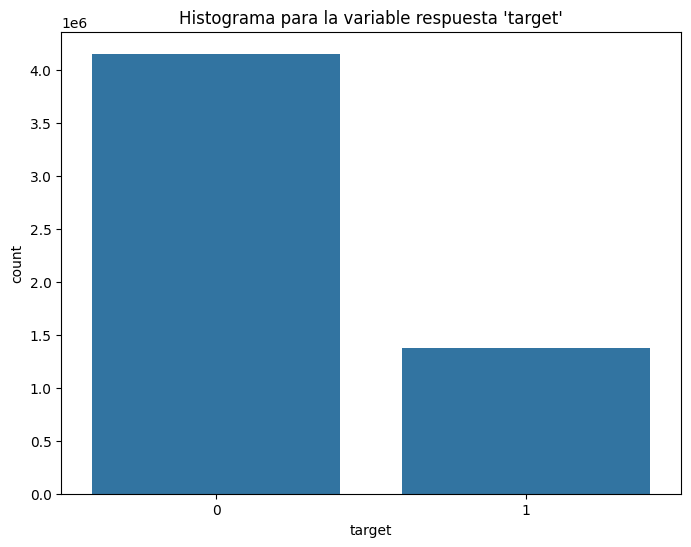

In [6]:
def describe_data(df, target_variable):
    # Calcular estadísticas descriptivas generales para todas las columnas numéricas
    stats = df.describe()

    # Contar los valores faltantes por columna
    missing_data = df.isnull().sum()

    # Calcular el porcentaje de datos faltantes
    missing_percentage = (missing_data / len(df)) * 100

    # Histograma para la variable respuesta (target) categórica
    plt.figure(figsize=(8, 6))
    sns.countplot(x=target_variable, data=df)
    plt.title(f"Histograma para la variable respuesta '{target_variable}'")
    plt.show()



    return stats, missing_data, missing_percentage

stats, missing_data, missing_percentage = describe_data(df, 'target')


In [ ]:
    # Conteo de datos faltantes y porcentaje

numero_observaciones = df.shape[0]
datos_faltantes = df.isnull().sum()
porcentaje_faltantes = (df.isnull().sum() / df.shape[0]) * 100

print(f"Numero de observaciones: {numero_observaciones}")
print("Estadísticas descriptivas:")
print(stats)
print("\nDatos faltantes por columna:")
print(datos_faltantes)
print("\nPorcentaje de datos faltantes por columna:")
print(porcentaje_faltantes)

Numero de observaciones: 5531451
Estadísticas descriptivas:
                                 S_2           P_2          D_39  \
count                        5531451  5.485466e+06  5.531451e+06   
mean   2017-09-20 21:47:03.013998080           NaN           NaN   
min              2017-03-01 00:00:00 -4.589844e-01  0.000000e+00   
25%              2017-06-15 00:00:00  4.802246e-01  4.528046e-03   
50%              2017-09-23 00:00:00  6.943359e-01  9.056091e-03   
75%              2017-12-29 00:00:00  8.647461e-01  2.366943e-01   
max              2018-03-31 00:00:00  1.009766e+00  5.390625e+00   
std                              NaN  0.000000e+00  0.000000e+00   

                B_1           B_2           R_1           S_3          D_41  \
count  5.531451e+06  5.529435e+06  5.531451e+06  4.510907e+06  5.529435e+06   
mean            NaN           NaN           NaN           NaN           NaN   
min   -7.589844e+00  0.000000e+00  0.000000e+00 -6.269531e-01  0.000000e+00   
25%    8.86

**Número de observaciones:** El conjunto de datos tiene 5.5 millones de registros.

**Estadísticas descriptivas:** Las variables numéricas presentan valores variados con algunas distribuciones asimétricas, y target está desbalanceada con un 24.9% de registros en la clase 1.

**Datos faltantes:** Varias columnas tienen un porcentaje significativo de datos faltantes, con algunas como D_142 presentando hasta un 82.92% de valores nulos.

**General:** El dataset está desbalanceado y requiere imputación de datos faltantes antes del modelado.

## PCA, encoder e Iterative Imputer
Se tomo la decision que antes de hacer el analisis de las variables se haria un PCA para analizar el comportamiento de las variables que aporten mayor variabilidad para posterior implementacion en el modelo.

Para eso el dataset tiene que estar completo y sin valores faltantes motivo por el cual habia que hacer imputacion, atendiendo la sugerencia, se uso el **Iterative Imputer** y posterior se realizo un PCA con las variables que aportaban un 75 % de los datos. Ademas se elimino las variables que tenian el 50 % de los datos faltantes ya que imputarlas pueden incurrir en un sesgo despues.

In [7]:
# Calcula el porcentaje de valores faltantes por columna
missing_percentage = df.isnull().sum() / len(df) * 100

# Identifica las columnas con más del 50% de valores faltantes
columns_to_drop = missing_percentage[missing_percentage > 50].index.tolist()

# Imprime las columnas que se eliminarán
print("Columnas con más del 50% de datos faltantes que se eliminarán:")
print(columns_to_drop)

# Elimina las columnas
df = df.drop(columns=columns_to_drop)

Columnas con más del 50% de datos faltantes que se eliminarán:
['D_42', 'D_49', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_66', 'D_73', 'D_76', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88', 'D_105', 'D_106', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39', 'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_142']


In [8]:
import pandas as pd

# Ajustar las opciones de visualización de pandas
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas

# Calcular el porcentaje de datos faltantes por columna
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Crear un DataFrame con el nombre de la variable y el porcentaje de datos faltantes
missing_data_table = pd.DataFrame({
    'Variable': df.columns,
    'Porcentaje de Datos Faltantes': missing_percentage
})

# Mostrar la tabla completa sin truncar
print(missing_data_table)

                Variable  Porcentaje de Datos Faltantes
customer_ID  customer_ID                       0.000000
S_2                  S_2                       0.000000
P_2                  P_2                       0.831337
D_39                D_39                       0.000000
B_1                  B_1                       0.000000
B_2                  B_2                       0.036446
R_1                  R_1                       0.000000
S_3                  S_3                      18.449843
D_41                D_41                       0.036446
B_3                  B_3                       0.036446
D_43                D_43                      29.981211
D_44                D_44                       4.959259
B_4                  B_4                       0.000000
D_45                D_45                       0.036464
B_5                  B_5                       0.000000
R_2                  R_2                       0.000000
D_46                D_46                      21

## Imputacion
Notamos que nos quedaron de igual forma variables con datos faltantes, como primera medida imputamos las categoricas por KNN y despues hacemos encoder que en este caso usamos **Hashing** por velocidad de ejecucion.

In [10]:
categorical_columns = df.select_dtypes(include=['object']).columns

# Llenar valores faltantes temporales con una cadena "missing" para no perder información
df[categorical_columns] = df[categorical_columns].fillna('missing')

# Usar HashingEncoder para convertir las variables categóricas a numéricas
hashing_encoder = ce.HashingEncoder(cols=categorical_columns, n_components=8)  # n_components define la cantidad de columnas de salida
df_encoded = hashing_encoder.fit_transform(df)

# Seleccionar solo las columnas numéricas para aplicar el imputador
df_numeric = df_encoded.select_dtypes(include=[float, int])

# Aplicar KNNImputer
imputer = KNNImputer(n_neighbors=3)
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

Luego corrimos el codigo para hacer el **Iterative Imputer** en una maquina virtual y lo guardamos en el Siguiente pickle, luego le devolvimos los nombres de las columnas al dataset posterior imputacion y lo guardamos bajo el nombre de df_combined.

In [11]:
pickle_file_path = '/content/drive/MyDrive/Parcial 2/DATA/imputed_ddf.pkl'
dfn = df.select_dtypes(include=['number'])
# Cargar el dataframe desde el archivo pickle
df_from_pickle = pd.read_pickle(pickle_file_path)

dfact = pd.DataFrame(df_from_pickle.values, columns=dfn.columns)

# Mostrar el nuevo dataframe
dfact

df_combined = pd.concat([dfact, df_imputed], axis=1)

# Mostrar las primeras filas del dataframe combinado
print(df_combined.head())

        P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0  0.938477  0.001734  0.008728  1.006836  0.009224  0.124023  0.008774   
1  0.936523  0.005775  0.004925  1.000977  0.006153  0.126709  0.000798   
2  0.954102  0.091492  0.021652  1.009766  0.006817  0.123962  0.007599   
3  0.960449  0.002455  0.013687  1.002930  0.001372  0.117188  0.000685   
4  0.947266  0.002483  0.015190  1.000977  0.007607  0.117310  0.004654   

        B_3      D_43      D_44       B_4      D_45       B_5       R_2  \
0  0.004707  0.041415  0.000630  0.080994  0.708984  0.170654  0.006203   
1  0.002714  0.041787  0.002525  0.069397  0.712891  0.113220  0.006207   
2  0.009422  0.042707  0.007607  0.068848  0.720703  0.060486  0.003260   
3  0.005531  0.046785  0.006405  0.055634  0.724121  0.166748  0.009918   
4  0.009308  0.035551  0.007732  0.038849  0.720703  0.143677  0.006668   

       D_46      D_47      D_48       B_6       B_7       B_8      D_51  \
0  0.358643  0.525391  

## PCA

En esta parte hicimos un testeo de manera que al final nos quedara aproximandamente 75% de la variabilidad con los nombres de las respectivas variables.

Se seleccionaron las 10 variables con mas representatividad en el PCA para el analisis, y se tomaron 10 variables bivariadas.

In [12]:
df_pca = df_combined.drop(columns=[col for col in df_combined.columns if 'target' in col])

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Paso 1: Asegurarse de que todas las columnas son numéricas
df_numeric = df_pca.select_dtypes(include=[np.number])

# Paso 2: Estandarizar los datos (esto mejora el desempeño de PCA)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Paso 3: Aplicar PCA
pca = PCA(n_components=57)  # Elegir el número de componentes principales
pca.fit(df_scaled)

# Obtener la proporción de varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Paso 4: Mostrar los resultados
print("Proporción de varianza explicada por cada componente principal:")
print(explained_variance)

# Paso 5: Obtener las 10 variables que más contribuyen a los componentes principales
# Los componentes principales son combinaciones lineales de las variables originales
components = pca.components_

# Crear un DataFrame para mostrar las contribuciones de cada variable en los componentes principales
contributions = pd.DataFrame(components.T, index=df_numeric.columns, columns=[f'PC{i+1}' for i in range(57)])

# Mostrar las 10 variables más importantes para los primeros componentes
print("\nContribución de las variables a los componentes principales:")
print(contributions.abs().sum(axis=1).sort_values(ascending=False).head(57))

Proporción de varianza explicada por cada componente principal:
[0.11773662 0.04450297 0.03959566 0.03548287 0.0264503  0.02372033
 0.02083673 0.01939401 0.01836167 0.01778969 0.01615116 0.01533399
 0.0141989  0.01340845 0.01285012 0.0116037  0.0110999  0.01049243
 0.01039236 0.01004755 0.00955847 0.00913555 0.0089887  0.00848955
 0.00839656 0.00832296 0.00772878 0.00749085 0.00733716 0.00733261
 0.00732973 0.00732716 0.0073251  0.00732253 0.00732    0.00728217
 0.00721854 0.00709272 0.00677354 0.00668775 0.00662801 0.00658408
 0.00654853 0.00646577 0.00644799 0.00642375 0.00641232 0.00640063
 0.00637398 0.00636016 0.00633024 0.00628649 0.00627525 0.00622625
 0.00615635 0.0061335  0.00611483]

Contribución de las variables a los componentes principales:
B_36     4.121028
R_28     4.022967
S_17     4.001796
D_93     3.999127
D_69     3.996105
S_23     3.935610
D_109    3.854335
D_140    3.837579
R_22     3.805673
D_124    3.764517
D_65     3.742315
B_32     3.707434
B_41     3.684262
S_

Se seleccionaron manualmente las variables del 75% de la variabilidad.

In [14]:
selected_columns = [
    'B_36', 'R_28', 'S_17', 'D_93', 'D_69', 'S_23', 'D_109', 'D_140', 'R_22', 'D_124',
    'D_65', 'B_32', 'B_41', 'S_12', 'D_46', 'R_10', 'B_40', 'B_27', 'B_26', 'D_83',
    'B_31', 'R_14', 'D_129', 'D_91', 'D_51', 'P_3', 'B_10', 'S_22', 'B_6', 'R_18',
    'R_19', 'D_52', 'R_6', 'S_24', 'D_128', 'S_7', 'D_61', 'R_7', 'B_12', 'P_4',
    'D_144', 'S_6', 'S_27', 'S_5', 'D_94', 'D_123', 'R_15', 'S_19', 'S_3', 'R_25',
    'D_78', 'D_54', 'D_71', 'S_25', 'S_11', 'D_125', 'D_41', 'target'
]

# Crear el nuevo dataframe con las columnas seleccionadas
data = df_combined[selected_columns]

# Mostrar las primeras filas del nuevo dataframe
data.head()

,B_36,R_28,S_17,D_93,D_69,S_23,D_109,D_140,R_22,D_124,D_65,B_32,B_41,S_12,D_46,R_10,B_40,B_27,B_26,D_83,B_31,R_14,D_129,D_91,D_51,P_3,B_10,S_22,B_6,R_18,R_19,D_52,R_6,S_24,D_128,S_7,D_61,R_7,B_12,P_4,D_144,S_6,S_27,S_5,D_94,D_123,R_15,S_19,S_3,R_25,D_78,D_54,D_71,S_25,S_11,D_125,D_41,target,target
0,0.009972,0.001534,0.008034,0.003569,0.009010,0.135620,0.004326,0.003706,0.007481,0.686523,0.007126,0.006626,0.006805,0.271973,0.358643,0.007122,0.210083,0.002310,0.000272,0.007042,1.0,0.000438,1.000000,1.503906,1.335938,0.736328,0.096191,0.894043,0.063904,0.008911,0.005177,0.207275,0.008362,0.911133,1.007812,0.161377,0.308350,0.007561,0.148315,0.007553,0.000610,0.008324,0.676758,0.023376,0.008873,0.003057,0.006451,0.002537,0.124023,0.003647,0.001575,1.001953,0.119385,0.974609,0.401611,0.008743,0.008774,0.0,0.0
1,0.003922,0.004932,0.000761,0.000571,0.007843,0.136353,0.008705,0.003166,0.006828,0.686523,0.002413,0.001854,0.004406,0.188965,0.353516,0.005966,0.184082,0.001327,0.000978,0.007790,1.0,0.004311,1.008789,1.503906,1.339844,0.720703,0.099792,0.902344,0.065247,0.005905,0.008980,0.202759,0.004028,0.919922,1.003906,0.140991,0.265137,0.005302,0.143555,0.004833,0.005493,0.002481,0.822266,0.030594,0.000391,0.001306,0.002333,0.008430,0.126709,0.008850,0.009895,1.008789,0.140625,0.975586,0.406250,0.000755,0.000798,0.0,0.0
2,0.001264,0.009125,0.004055,0.007427,0.006023,0.134888,0.004093,0.007328,0.009819,0.689941,0.001878,0.008690,0.003222,0.495361,0.334717,0.005447,0.154785,0.007626,0.006149,0.004093,1.0,0.007141,1.006836,1.502930,1.336914,0.738281,0.134033,0.939453,0.066956,0.008881,0.002016,0.206665,0.006840,0.958496,1.007812,0.112244,0.212158,0.001422,0.136963,0.006561,0.006985,0.000530,0.853516,0.048370,0.009232,0.003956,0.008362,0.007328,0.123962,0.009766,0.009628,1.008789,0.075867,0.974121,0.406738,0.009621,0.007599,0.0,0.0
3,0.002729,0.002409,0.006969,0.000664,0.005272,0.140015,0.009705,0.004517,0.000458,0.687988,0.005898,0.002478,0.007702,0.508789,0.323242,0.001888,0.153931,0.000034,0.009193,0.008820,1.0,0.008690,1.007812,1.503906,1.339844,0.741699,0.134399,0.913086,0.083740,0.008347,0.003910,0.208252,0.008186,0.926270,1.003906,0.102844,0.204346,0.006363,0.129028,0.009560,0.006527,0.000783,0.844727,0.030060,0.003201,0.005135,0.007362,0.007053,0.117188,0.004856,0.008568,1.007812,0.150269,0.975586,0.405273,0.004650,0.000685,0.0,0.0
4,0.009995,0.004463,0.001770,0.003078,0.000152,0.131592,0.009117,0.004944,0.003342,0.688965,0.009476,0.002199,0.009827,0.216553,0.230957,0.006111,0.120728,0.002110,0.005737,0.001844,1.0,0.007812,1.007812,1.509766,1.341797,0.691895,0.121521,0.920898,0.075928,0.002678,0.003431,0.205444,0.008606,0.933594,1.004883,0.094299,0.175659,0.004829,0.129517,0.008156,0.008125,0.006699,0.811035,0.054230,0.003845,0.002850,0.002470,0.007729,0.117310,0.002983,0.003288,1.003906,0.096436,0.978027,0.487549,0.000097,0.004654,0.0,0.0


In [15]:
data = data.iloc[:, :-1]
drive.mount('/content/drive')

# Guardar el dataframe en un archivo pickle
file_path = '/content/drive/MyDrive/Parcial 2/DATA/data.pkl'
data.to_pickle(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Analisis 10 variables


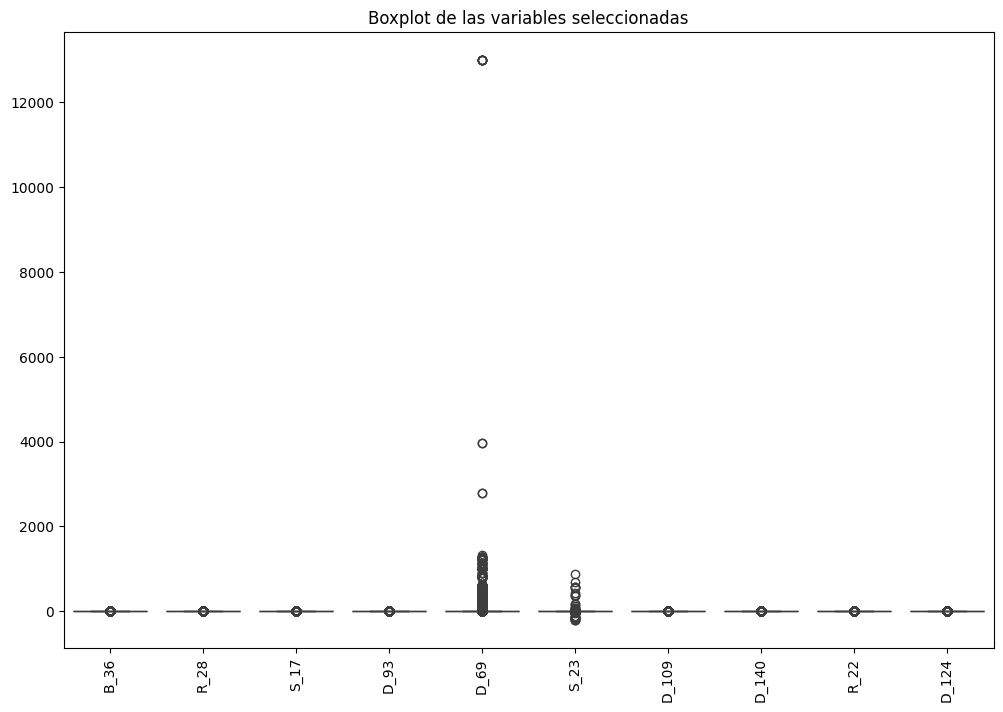

In [16]:
# Seleccionar las columnas especificadas
columnas_seleccionadas = ['B_36', 'R_28', 'S_17', 'D_93', 'D_69', 'S_23', 'D_109', 'D_140', 'R_22', 'D_124']
df_seleccionado = df[columnas_seleccionadas]

# Crear el boxplot para analizar la simetría, atípicos y dispersión de las variables seleccionadas
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_seleccionado)
plt.title('Boxplot de las variables seleccionadas')
plt.xticks(rotation=90)
plt.show()

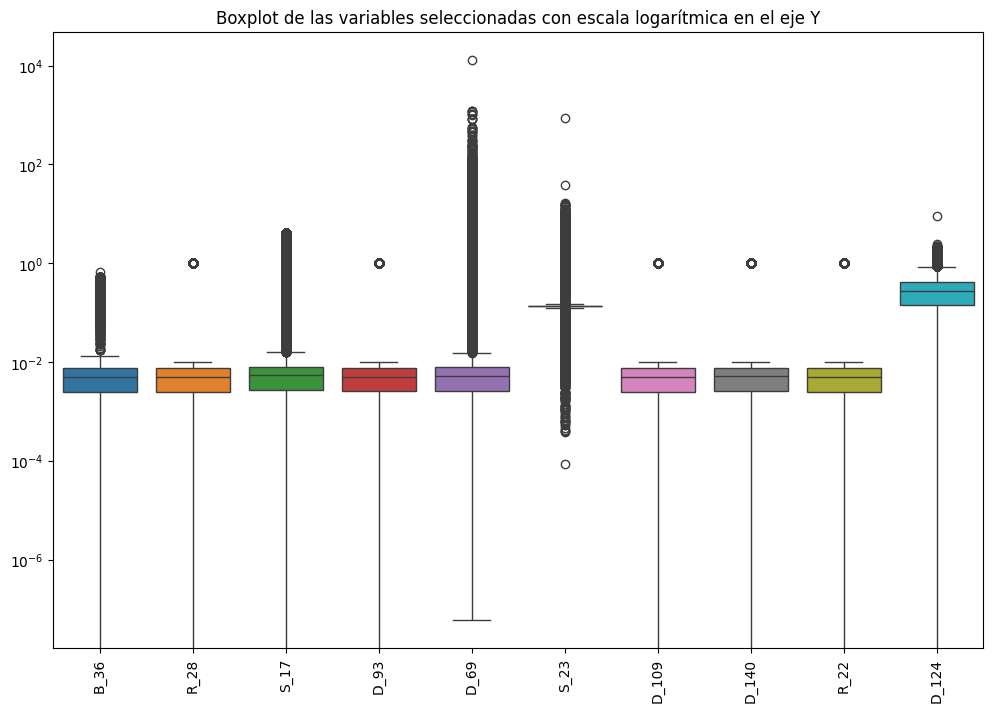

In [18]:
# Seleccionar las columnas especificadas
columnas_seleccionadas = ['B_36', 'R_28', 'S_17', 'D_93', 'D_69', 'S_23', 'D_109', 'D_140', 'R_22', 'D_124']

# Si el dataset es muy grande, puedes tomar una muestra de los datos
df_seleccionado = df[columnas_seleccionadas].sample(frac=0.1, random_state=42)  # Tomar el 10% del dataset

# Crear el boxplot para analizar la simetría, atípicos y dispersión de las variables seleccionadas
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_seleccionado)
plt.yscale('log')  # Aplicar escala logarítmica en el eje Y
plt.title('Boxplot de las variables seleccionadas con escala logarítmica en el eje Y')
plt.xticks(rotation=90)
plt.show()

1. ***Simetría y dispersión:*** Las variables como B_36, R_28, S_17, y otras, presentan datos distribuidos en una escala logarítmica. Esto indica una gran dispersión en los valores. La mayoría de los datos están cercanos al centro de la caja (mediana), pero se extienden mucho hacia los valores más altos.

2. ***Datos atípicos:*** Las variables como S_23 y D_69 tienen un gran número de outliers, lo que puede significar que estas variables tienen valores extremos o atípicos en comparación con el resto de los datos.

3. ***Dispersión:*** Las variables están distribuidas en un rango amplio, algunas como D_109 y R_22 muestran una menor dispersión, mientras que otras como D_69 muestran una dispersión muy alta, evidenciado por la gran longitud de los bigotes en el gráfico.

## Analisis Bivariado



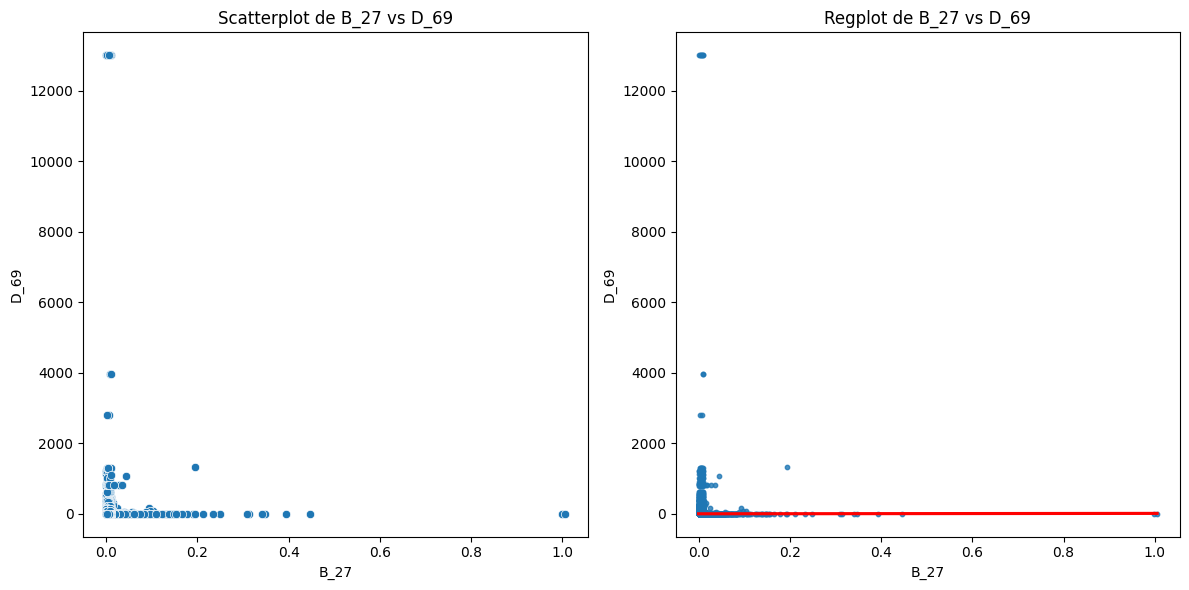

Análisis de B_27 vs D_69:
- El gráfico de dispersión muestra la relación entre B_27 y D_69. Si los puntos están más dispersos, la relación entre las variables es más débil.
- El gráfico de regresión agrega una línea de ajuste. Si la pendiente es pronunciada, puede haber una relación más fuerte entre las variables.
- Si los puntos están agrupados cerca de la línea de regresión, la relación es más fuerte.
- Analiza la forma de los puntos: si ves una relación lineal, cuadrática u otro patrón. También presta atención a los valores atípicos.
- Observa si las variables muestran colinealidad, lo que puede ser útil para construir modelos predictivos.




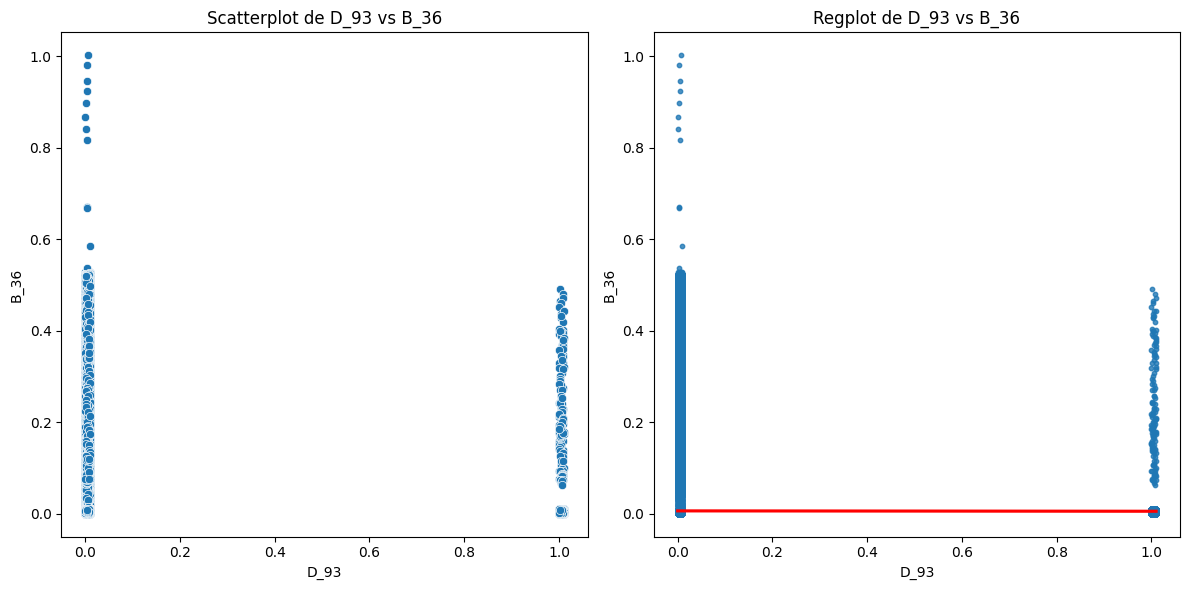

Análisis de D_93 vs B_36:
- El gráfico de dispersión muestra la relación entre D_93 y B_36. Si los puntos están más dispersos, la relación entre las variables es más débil.
- El gráfico de regresión agrega una línea de ajuste. Si la pendiente es pronunciada, puede haber una relación más fuerte entre las variables.
- Si los puntos están agrupados cerca de la línea de regresión, la relación es más fuerte.
- Analiza la forma de los puntos: si ves una relación lineal, cuadrática u otro patrón. También presta atención a los valores atípicos.
- Observa si las variables muestran colinealidad, lo que puede ser útil para construir modelos predictivos.




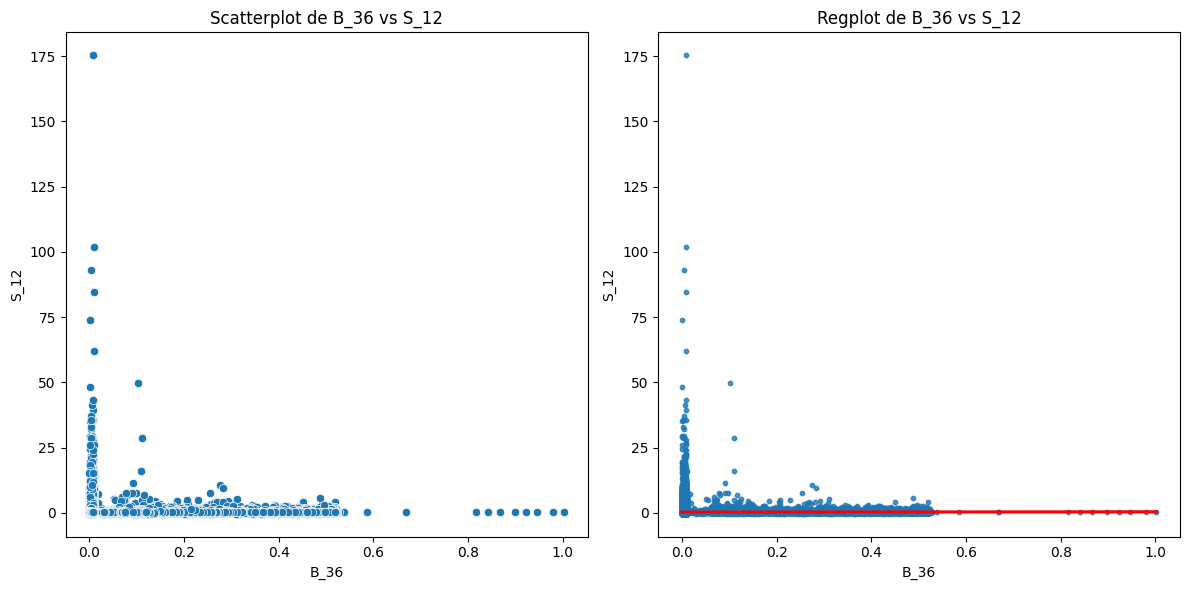

Análisis de B_36 vs S_12:
- El gráfico de dispersión muestra la relación entre B_36 y S_12. Si los puntos están más dispersos, la relación entre las variables es más débil.
- El gráfico de regresión agrega una línea de ajuste. Si la pendiente es pronunciada, puede haber una relación más fuerte entre las variables.
- Si los puntos están agrupados cerca de la línea de regresión, la relación es más fuerte.
- Analiza la forma de los puntos: si ves una relación lineal, cuadrática u otro patrón. También presta atención a los valores atípicos.
- Observa si las variables muestran colinealidad, lo que puede ser útil para construir modelos predictivos.




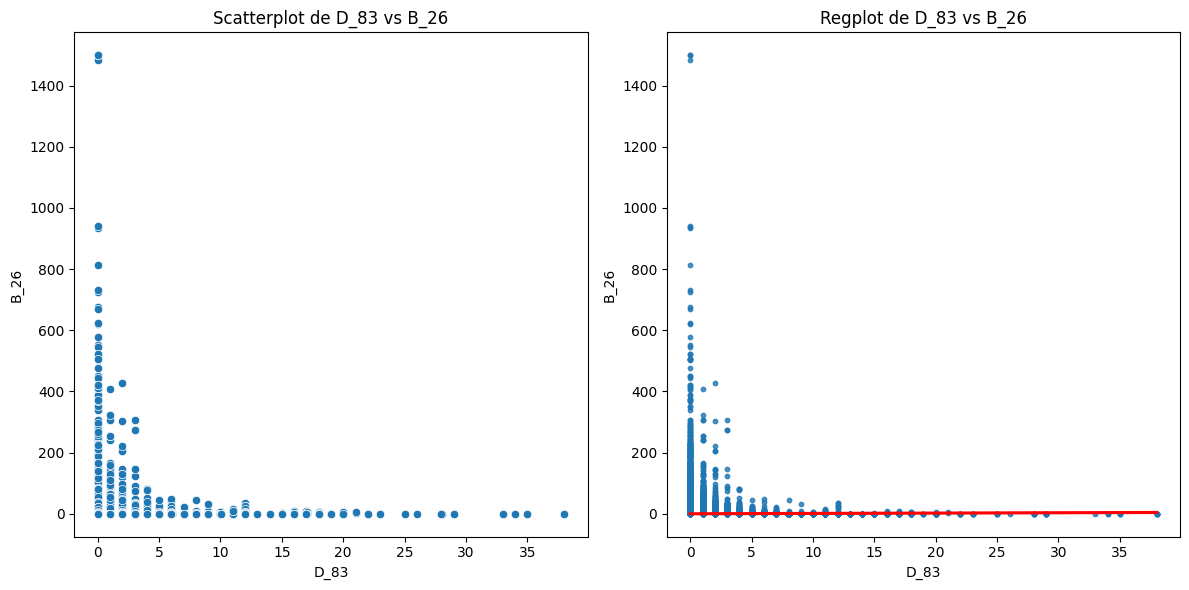

Análisis de D_83 vs B_26:
- El gráfico de dispersión muestra la relación entre D_83 y B_26. Si los puntos están más dispersos, la relación entre las variables es más débil.
- El gráfico de regresión agrega una línea de ajuste. Si la pendiente es pronunciada, puede haber una relación más fuerte entre las variables.
- Si los puntos están agrupados cerca de la línea de regresión, la relación es más fuerte.
- Analiza la forma de los puntos: si ves una relación lineal, cuadrática u otro patrón. También presta atención a los valores atípicos.
- Observa si las variables muestran colinealidad, lo que puede ser útil para construir modelos predictivos.




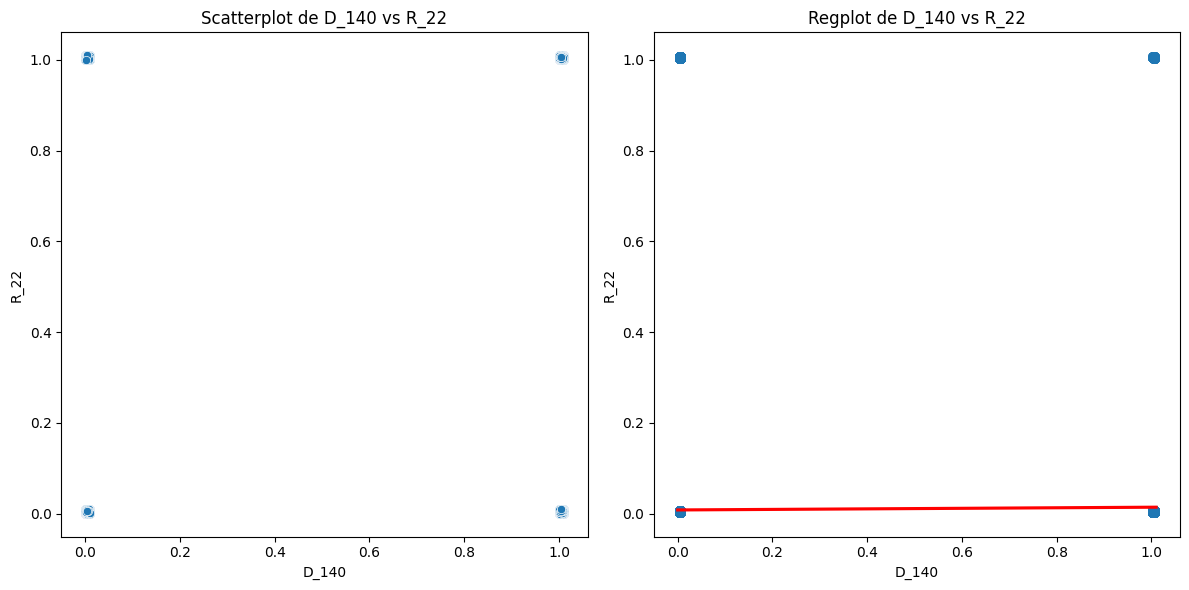

Análisis de D_140 vs R_22:
- El gráfico de dispersión muestra la relación entre D_140 y R_22. Si los puntos están más dispersos, la relación entre las variables es más débil.
- El gráfico de regresión agrega una línea de ajuste. Si la pendiente es pronunciada, puede haber una relación más fuerte entre las variables.
- Si los puntos están agrupados cerca de la línea de regresión, la relación es más fuerte.
- Analiza la forma de los puntos: si ves una relación lineal, cuadrática u otro patrón. También presta atención a los valores atípicos.
- Observa si las variables muestran colinealidad, lo que puede ser útil para construir modelos predictivos.




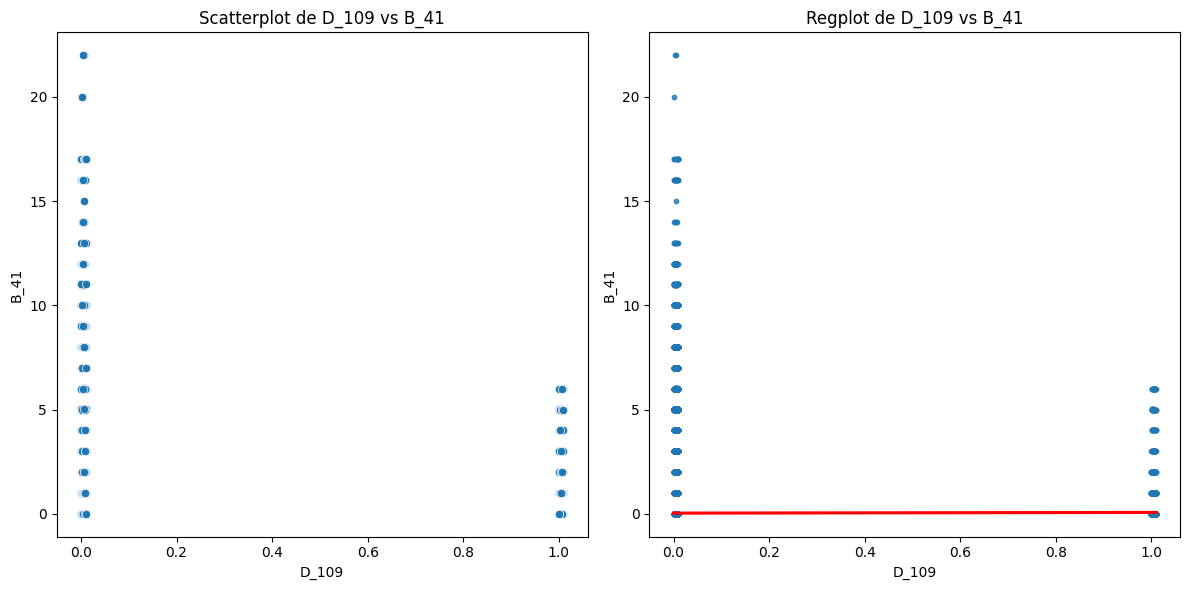

Análisis de D_109 vs B_41:
- El gráfico de dispersión muestra la relación entre D_109 y B_41. Si los puntos están más dispersos, la relación entre las variables es más débil.
- El gráfico de regresión agrega una línea de ajuste. Si la pendiente es pronunciada, puede haber una relación más fuerte entre las variables.
- Si los puntos están agrupados cerca de la línea de regresión, la relación es más fuerte.
- Analiza la forma de los puntos: si ves una relación lineal, cuadrática u otro patrón. También presta atención a los valores atípicos.
- Observa si las variables muestran colinealidad, lo que puede ser útil para construir modelos predictivos.




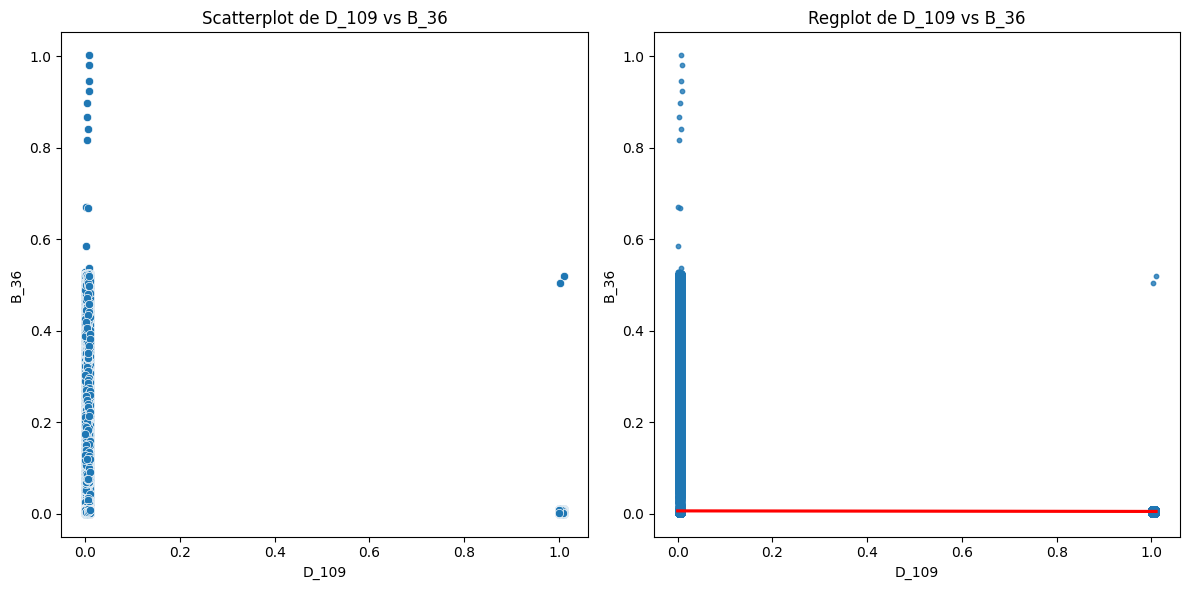

Análisis de D_109 vs B_36:
- El gráfico de dispersión muestra la relación entre D_109 y B_36. Si los puntos están más dispersos, la relación entre las variables es más débil.
- El gráfico de regresión agrega una línea de ajuste. Si la pendiente es pronunciada, puede haber una relación más fuerte entre las variables.
- Si los puntos están agrupados cerca de la línea de regresión, la relación es más fuerte.
- Analiza la forma de los puntos: si ves una relación lineal, cuadrática u otro patrón. También presta atención a los valores atípicos.
- Observa si las variables muestran colinealidad, lo que puede ser útil para construir modelos predictivos.




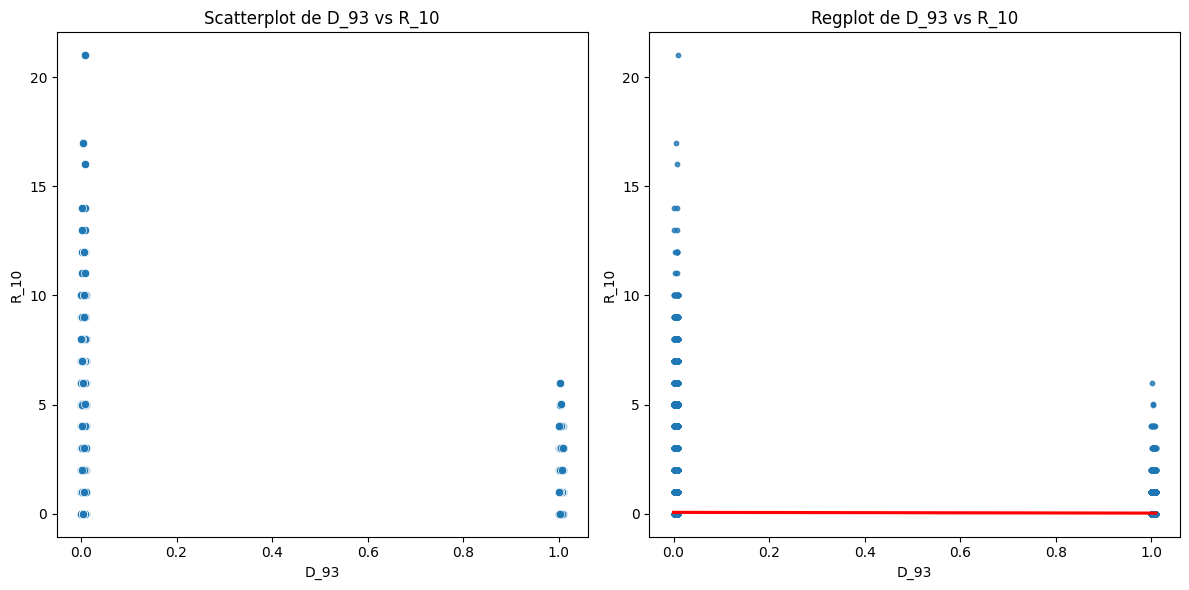

Análisis de D_93 vs R_10:
- El gráfico de dispersión muestra la relación entre D_93 y R_10. Si los puntos están más dispersos, la relación entre las variables es más débil.
- El gráfico de regresión agrega una línea de ajuste. Si la pendiente es pronunciada, puede haber una relación más fuerte entre las variables.
- Si los puntos están agrupados cerca de la línea de regresión, la relación es más fuerte.
- Analiza la forma de los puntos: si ves una relación lineal, cuadrática u otro patrón. También presta atención a los valores atípicos.
- Observa si las variables muestran colinealidad, lo que puede ser útil para construir modelos predictivos.




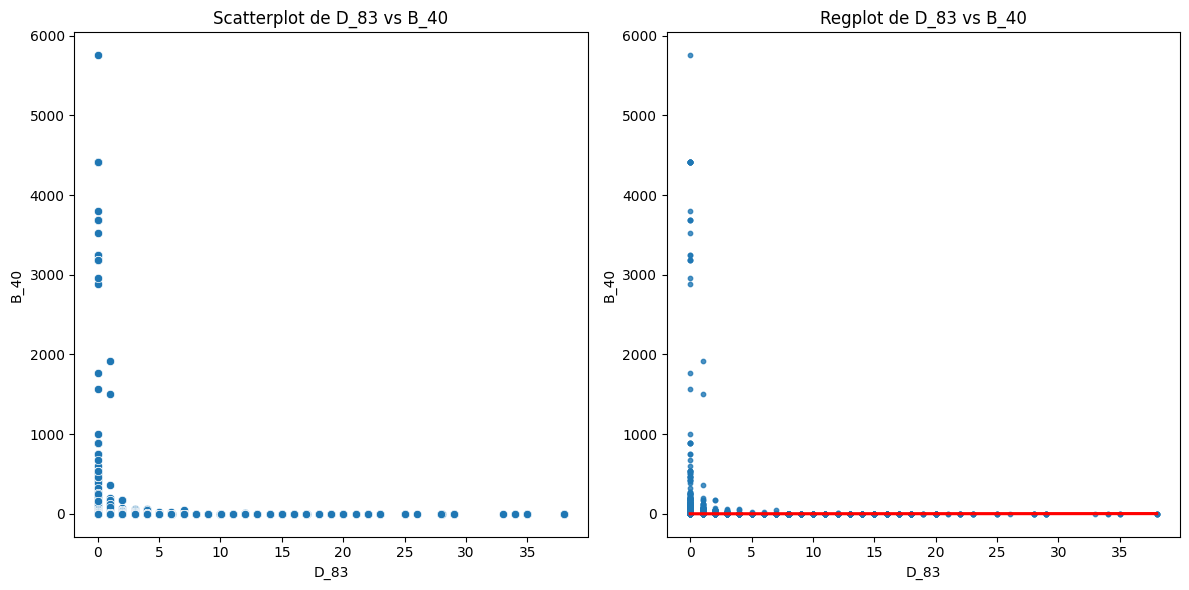

Análisis de D_83 vs B_40:
- El gráfico de dispersión muestra la relación entre D_83 y B_40. Si los puntos están más dispersos, la relación entre las variables es más débil.
- El gráfico de regresión agrega una línea de ajuste. Si la pendiente es pronunciada, puede haber una relación más fuerte entre las variables.
- Si los puntos están agrupados cerca de la línea de regresión, la relación es más fuerte.
- Analiza la forma de los puntos: si ves una relación lineal, cuadrática u otro patrón. También presta atención a los valores atípicos.
- Observa si las variables muestran colinealidad, lo que puede ser útil para construir modelos predictivos.




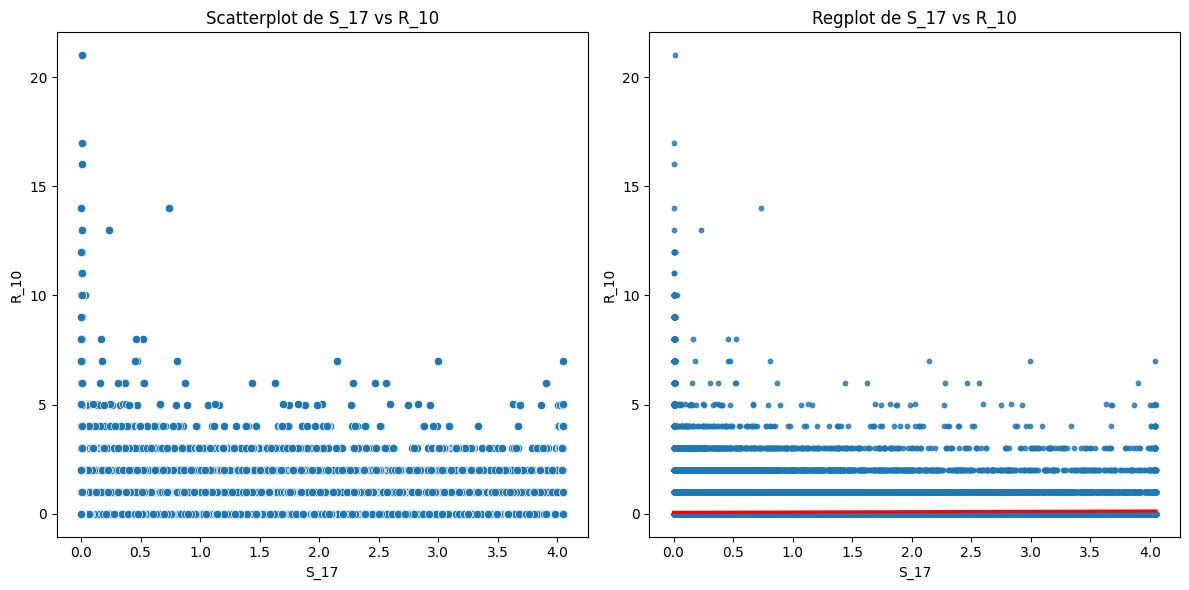

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Variables seleccionadas
variables = ['B_36', 'R_28', 'S_17', 'D_93', 'D_69', 'S_23', 'D_109', 'D_140', 'R_22', 'D_124',
             'D_65', 'B_32', 'B_41', 'S_12', 'D_46', 'R_10', 'B_40', 'B_27', 'B_26', 'D_83']

# Seleccionar 10 pares aleatorios de variables
random.seed(42)  # Fijar la semilla para reproducibilidad
random_pairs = random.sample([(x, y) for x in variables for y in variables if x != y], 10)

# Trazado de scatterplot y regplot para los pares seleccionados
for pair in random_pairs:
    x_var, y_var = pair
    plt.figure(figsize=(12, 6))

    # Scatterplot
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=x_var, y=y_var, data=df)
    plt.title(f'Scatterplot de {x_var} vs {y_var}')

    # Regplot
    plt.subplot(1, 2, 2)
    sns.regplot(x=x_var, y=y_var, data=df, scatter_kws={'s':10}, line_kws={'color':'red'})
    plt.title(f'Regplot de {x_var} vs {y_var}')

    # Mostrar los gráficos
    plt.tight_layout()
    plt.show()

    # Análisis básico
    print(f"Análisis de {x_var} vs {y_var}:")
    print(f"- El gráfico de dispersión muestra la relación entre {x_var} y {y_var}. Si los puntos están más dispersos, la relación entre las variables es más débil.")
    print(f"- El gráfico de regresión agrega una línea de ajuste. Si la pendiente es pronunciada, puede haber una relación más fuerte entre las variables.")
    print(f"- Si los puntos están agrupados cerca de la línea de regresión, la relación es más fuerte.")
    print("- Analiza la forma de los puntos: si ves una relación lineal, cuadrática u otro patrón. También presta atención a los valores atípicos.")
    print("- Observa si las variables muestran colinealidad, lo que puede ser útil para construir modelos predictivos.")
    print("\n")


En esta parte nos podemos dar cuenta como estas variables no se encuentran correlacionadas entre ellas, esto debido a que son tomadas del PCA por lo cual ese es un fin del mismo, elegir las variables con menos relacion y mas variabilidad, lo que nos permite eliminar el resto del dataset sin necesidad de hacer VIF. Eligiendo como metodo de reduccion de dimensionalidad el PCA con el umbral de 75%.

Teniendo ya las variables seleccionadas y los datos limpios e imputados Pasamos al analisis de los Modelos.